# ***Importando as bibliotecas necessárias***

In [1]:
import pandas as pd
import numpy as np

import time

from typing import Union, Tuple, Optional

from numpy import linalg as la
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

# ***Setando os parâmetros do modelo***

In [29]:
params = {
    'filepath': 'dataBTC.xlsx',  # Caminho do arquivo '.xlsx' com os dados de entrada.
    
    'delay': 5,  # Número de atrasos (lags) usados como entrada para o modelo fuzzy. Ex: para delay=5, usa-se x[t-1] a x[t-5].
    
    'rules_number': 10,  # Número de regras fuzzy a serem utilizadas no modelo. Cada regra representa uma "região" do espaço de entrada.
    
    'alfa': 1000,  # Valor inicial para a matriz de ganho P0 = alfa * I no algoritmo de mínimos quadrados recursivo (equação 11). 
                   # Um valor grande permite atualizações maiores no início do treinamento.
    
    'lamb': 0.99,  # Fator de esquecimento (λ) que regula a influência dos dados antigos na atualização dos coeficientes.
                   # Valores próximos de 1 consideram o histórico mais fortemente. 
    
    'n': 999,   # Índice (linha) do último dado usado no conjunto de treinamento (inclusive).
    'm': 2524,  # Índice (linha) do último dado considerado no teste (inclusive).
    
    'kz': None,  # Constante do kernel gaussiano (define a intensidade de ativação). 

    'zs': None   # Constante do kernel gaussiano (controla a largura da ativação).
}   

In [ ]:
# Atribuição direta dos parâmetros a variáveis para facilitar o uso posterior no código

filepath = params['filepath']  # Caminho do arquivo de dados

delay = params['delay']  # Número de atrasos usados como entrada

rules_number = params['rules_number']  # Número de regras fuzzy

alfa = params['alfa']  # Valor inicial da matriz de ganho (P0)

lamb = params['lamb']  # Fator de esquecimento no algoritmo de atualização

n = params['n']  # Último índice da base de treinamento

m = params['m']  # Último índice da base de teste

kz = params['kz']  # Constante do kernel gaussiano (define a intensidade de ativação).  

zs = params['zs']  # Constante do kernel gaussiano (controla a largura da ativação). 

# Cálculo de constantes do kernel Gaussiano (se necessário) para uso nas equações de atualização

if kz is None:
    kc = 1 / np.sqrt(2 * np.pi)
    ze = 1.0
    kz = kc / (ze ** 3)  
    
if zs is None:
    ze = 1.0
    zs = 1 / (2 * ze ** 2) 

In [3]:
# Função temporária (provavelmente será substituída por alguma variação do K-means).
def generate_centers_sigmas(n: int, d: int) -> tuple[np.ndarray, np.ndarray]:
    """
        Description:
            Gera aleatoriamente n centros e sigmas de dimensão d com valores entre 0 e 1.
            
        Args:
            n (int): Número de centros e sigmas a serem gerados.
            d (int): Dimensão de cada centro e sigma (delay).
        
        Return:
            tuple[np.ndarray, np.ndarray]: Retorna dois arrays numpy de shape (n, d),
            o primeiro representando os centros e o segundo os sigmas.
    """
    
    centers = np.random.rand(n, d) # Gera os centros aleatoriamente com valores entre 0 e 1
    
    sigmas = np.random.rand(n, d)  # Gera os sigmas aleatoriamente com valores entre 0 e 1
    
    return centers, sigmas # Retorna os centros e sigmas gerados

In [ ]:
#centers, sigmas = generate_centers_sigmas(rules_number,delay) # Gera 5 centers e sigmas, cada um com delay dimensões.

In [ ]:
# Valor original de delay no código 'alsmBTCtwo.py' (mantido aqui para teste de equivalência de resultados entre os códigos).
delay = 2

# Centers usados no código original do 'alsmBTCtwo.py' (mantidos aqui para teste de equivalência de resultados entre os códigos).
centers =  np.array([[0.10, 0.20],[0.80, 0.60]]) 
# Centers usados no código original do 'alsmBTCtwo.py' (mantidos aqui para teste de equivalência de resultados entre os códigos).
sigmas = np.array([[0.55, 0.40],[0.55, 0.40]]) 

# ***Declarando algumas funções que serão úteis nessa implementação***

## *Funções de plot*

In [6]:
def plot_line_series(
        series: Union[pd.Series, np.ndarray], 
        xlabel:str = 'x', 
        ylabel:str = 'y', 
        title:str = 'Line Plot', 
        label:str='Series'
    ) -> None:
    
    """
        Description:
            Plota uma série temporal ou sequência de valores como gráfico de linha.
            
        Args:
            series (pd.Series | np.ndarray): Sequência de valores a serem plotados.
            xlabel (str) [opcional]: Rótulo do eixo x. [Padrão: 'x'.]
            ylabel (str) [opcional]: Rótulo do eixo y. [Padrão: 'y'.]
            title (str) [opcional]: Título do gráfico. [Padrão: 'Line Plot'.]
            label (str) [opcional]: Legenda da série. [Padrão: 'Series'].
            
        Return:
            A função não retorna nada, apenas exibe um gráfico.
    """
    
    
    plt.figure() # Cria uma nova figura para o gráfico
    
    plt.plot(series, label=label) # Plota a série no gráfico com a legenda definida
    
    plt.xlabel(xlabel) # Define o rótulo do eixo x
    
    plt.ylabel(ylabel) # Define o rótulo do eixo y
    
    plt.title(title) # Define o título do gráfico
    
    plt.legend() # Exibe a legenda no gráfico
    
    plt.show() # Exibe o gráfico gerado

In [7]:
def plot_comparison_series(
    series_a: Union[pd.Series, np.ndarray],
    series_b: Union[pd.Series, np.ndarray],
    xlabel: str = 'x',
    ylabel: str = 'y',
    title: str = 'Comparison Plot',
    legend_labels: Tuple[str, str] = ('Series A', 'Series B'),
    ylim: Union[Tuple[float, float], None] = None
) -> None:
    """
        Description:
            Plota duas séries temporais (por exemplo, para fins comparativos) em um gráfico de linha.
        
        Args:
            series_a (pd.Series | np.ndarray): Primeira série a ser plotada.
            series_b (pd.Series | np.ndarray): Segunda série a ser plotada.
            xlabel (str) [opcional]: Rótulo do eixo x. [Padrão: 'x'.]
            ylabel (str) [opcional]: Rótulo do eixo y. [Padrão: 'y'.]
            title (str) [opcional]: Título do gráfico. [Padrão: 'Comparison Plot'.]
            legend_labels (tuple[str, str]) [opcional]: Rótulos para a legenda das duas séries. [Padrão: ('Series A', 'Series B').]
            ylim (tuple[float, float] | None) [opcional]: Limites do eixo y. [Padrão: None.]
        
        Return:
            A função não retorna nada, apenas exibe um gráfico comparativo.
    """

    plt.figure()  # Cria uma nova figura para o gráfico

    plt.plot(series_a, label=legend_labels[0])  # Plota a primeira série
    plt.plot(series_b, label=legend_labels[1])  # Plota a segunda série

    plt.xlabel(xlabel)  # Define o rótulo do eixo x
    plt.ylabel(ylabel)  # Define o rótulo do eixo y
    plt.title(title)  # Define o título do gráfico

    if ylim:
        plt.ylim(ylim)  # Define os limites do eixo y, se especificado

    plt.legend(loc='upper right')  # Adiciona a legenda no canto superior direito
    plt.show()  # Exibe o gráfico gerado

## *Função para gerar os dados de treino e teste*

In [8]:
def create_train_test_lagged_dataset(
    data: Union[pd.Series, np.ndarray], 
    train_start_idx: int,
    train_end_idx: int,
    test_start_idx: int,
    test_end_idx: int,
    delay: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    """
        Description:
            Cria conjuntos de treino e teste com defasagem (lagged datasets) a partir de uma série temporal.
        
        Args:
            data (pd.Series | np.ndarray | list): Série temporal original.
            train_start_idx (int): Índice inicial para o conjunto de treino.
            train_end_idx (int): Índice final para o conjunto de treino.
            test_start_idx (int): Índice inicial para o conjunto de teste.
            test_end_idx (int): Índice final para o conjunto de teste.
            delay (int): Número de defasagens (lags) a serem consideradas.
        
        Return:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Uma tupla contendo:
                - X_train: Matriz de features de treino com as defasagens, formato (n_train_samples, delay).
                - y_train: Vetor de alvos de treino, formato (n_train_samples,).
                - X_test: Matriz de features de teste com as defasagens, formato (n_test_samples, delay).
                - y_test: Vetor de alvos de teste, formato (n_test_samples,).
    """

    # Cria o conjunto de treino
    n_train_samples = train_end_idx - train_start_idx - delay + 1
    X_train = np.zeros((n_train_samples, delay)) # Matriz de entradas do conjunto de treino, cada linha com 'delay' lags
    y_train = np.zeros(n_train_samples) # Vetor de saídas (targets) do treino, correspondentes aos valores futuros após os lags

    for i in range(n_train_samples):
        for j in range(delay):
            X_train[i, j] = data[train_start_idx + i + j]
        y_train[i] = data[train_start_idx + i + delay]
    
    # Cria o conjunto de teste
    n_test_samples = test_end_idx - test_start_idx
    X_test = np.zeros((n_test_samples, delay)) # Matriz de entradas do conjunto de teste, com mesma estrutura de lags
    y_test = np.zeros(n_test_samples) # Vetor de saídas (targets) do teste, para avaliar a previsão do modelo
    
    for i in range(n_test_samples):
        for j in range(delay):
            X_test[i, j] = data[test_start_idx - delay + 1 + i + j]
        y_test[i] = data[test_start_idx + i + 1]
    
    return X_train, y_train, X_test, y_test

## *Funções de pertinência*

In [9]:
def gaussmf(
    x: Union[float, np.ndarray], 
    c: float, 
    s: float
) -> Union[float, np.ndarray]:
    
    """
        Description:
            Calcula o grau de pertinência usando uma função de pertinência gaussiana.
        
        Args:
            x (float | np.ndarray): Valor(es) de entrada para calcular o grau de pertinência.
            c (float): Centro da função gaussiana.
            s (float): Desvio padrão da função gaussiana.
        
        Return:
            float | np.ndarray: Grau de pertinência calculado para o(s) valor(es) de entrada.
    """
    
    aux = (x - c)/s  # Calcula a distância normalizada do valor ao centro
    z = np.exp(-(aux*aux)/2)  # Aplica a fórmula da função gaussiana
    return z

In [10]:
def gaussgranules(
    x: np.ndarray, 
    centers: np.ndarray, 
    sigmas: np.ndarray
) -> np.ndarray:
    
    """
        Description:
            Calcula as ativações de múltiplas regras fuzzy usando funções gaussianas.
        
        Args:
            x (np.ndarray): Vetor de entrada de dimensão d.
            centers (np.ndarray): Array de formato (N, d) com os centros das N regras.
            sigmas (np.ndarray): Array de formato (N, d) com os desvios padrão das N regras.
        
        Return:
            np.ndarray: Array de formato (N,) contendo o grau de ativação para cada uma das N regras.
    """
    
    # Um centro c = (c_{1},c_{2},...,c_{n}) e um desvio padrão s = (s_{1},s_{2},...,s_{n}) definem uma regra fuzzy (chamemos r).
    # Quando aplicamos gaussmf(x,c,s) para x = (x_{1},x_{2},...,x_{n}) obtemos o grau de pertencimento do vetor x à regra r.
    
    N, d = centers.shape  # N é o número de regras, d é a dimensão representada pelo delay
    activations = []  # Lista para armazenar as ativações de cada regra
    
    for i in range(N):
        mu = 1.0  # Inicializa o grau de pertinência como 1
        for j in range(d):
            # Multiplica o grau de pertinência pela ativação da j-ésima dimensão
            mu *= gaussmf(x[j], centers[i, j], sigmas[i, j]) # Multiplica o grau de pertinência da dimensão j de x à regra i
        activations.append(mu)  # Adiciona o resultado à lista de ativações
    
    return np.array(activations)  # Converte a lista para um array numpy

## *Funções para treinar o modelo*

In [32]:
def train_model(
    Xtrain: np.ndarray,
    ytrain: np.ndarray,
    r: int,
    lamb: float,
    alfa: float,
    kz: float,
    zs: float,
    centers: np.ndarray,
    sigmas: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    """
    Description:
        Treina um modelo ALSM com atualização online dos parâmetros.
        Usa ativações gaussianas e fator de confiança adaptativo psi.

    Args:
        Xtrain (np.ndarray): Dados de entrada de treinamento (n_amostras x n_features).
        ytrain (np.ndarray): Valores alvo reais para o treinamento.
        r (int): Número de regras fuzzy (granulações gaussianas).
        lamb (float): Fator de esquecimento (λ) para atualização recursiva.
        alfa (float): Valor inicial para a matriz de covariância P.
        kz (float): Constante do kernel gaussiano (definindo a intensidade de ativação).
        zs (float): Constante do kernel gaussiano (controla a largura da ativação).
        centers (np.ndarray): Vetor com os centros das funções gaussianas.
        sigmas (np.ndarray): Vetor com os desvios padrão das funções gaussianas.


    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            - OT: Saídas previstas pelo modelo no treinamento.
            - norm: Norma do vetor de parâmetros u a cada iteração.
            - u: Vetor de parâmetros finais do modelo.
            - P: Matriz de covariância adaptada final.
    """

    ndatatrain = Xtrain.shape[0]
    OT = np.zeros(ndatatrain)
    norm = np.zeros(ndatatrain)

    P = alfa * np.eye(2 * r)
    u = np.zeros(2 * r)
    a = np.zeros(2 * r)

    st = time.process_time()

    for t in range(ndatatrain):
        x = Xtrain[t]
        d = gaussgranules(x, centers, sigmas)
        sumd = np.sum(d)

        for j in range(r):
            a[2 * j]     = d[j]**2 / sumd
            a[2 * j + 1] = d[j]    / sumd

        erro = ytrain[t] - np.dot(a, u)
        sq = np.abs(erro)**2
        psi = kz * np.exp(-sq / zs)

        b = lamb + psi * np.dot(np.dot(a, P), a)
        Pa = np.dot(P, a)
        P = (P - psi * np.outer(Pa, Pa) / b) / lamb
        u += psi * np.dot(P, a) * erro

        OT[t] = np.dot(a, u)
        norm[t] = np.linalg.norm(u)

    et = time.process_time()
    print("CPU execution time (training):", et - st, "seconds")

    return OT, norm, u, P

In [33]:
def test_model(
    Xtest: np.ndarray,
    ytest: np.ndarray,
    r: int,
    lamb: float,
    P: np.ndarray,
    u: np.ndarray,
    centers: np.ndarray,
    sigmas: np.ndarray
) -> np.ndarray:
    
    """
    Description:
        Realiza a predição adaptativa com o modelo ALSM usando atualização online dos parâmetros
        para cada nova amostra do conjunto de teste.

    Args:
        Xtest (np.ndarray): Dados de entrada para teste (n_amostras x n_features).
        ytest (np.ndarray): Valores reais do conjunto de teste.
        r (int): Número de regras fuzzy (granulações gaussianas).
        lamb (float): Fator de esquecimento (λ) da atualização adaptativa.
        P (np.ndarray): Matriz de covariância proveniente do treinamento.
        u (np.ndarray): Vetor de parâmetros proveniente do treinamento.
        centers (np.ndarray): Centros das funções de pertinência gaussianas.
        sigmas (np.ndarray): Desvios padrão das funções gaussianas.

    Returns:
        np.ndarray: Saídas previstas (OS) para o conjunto de teste.
    """
    
    ndatatest = Xtest.shape[0]
    OS = np.zeros(ndatatest)
    a = np.zeros(2 * r)

    st = time.process_time()
    
    for t in range(ndatatest):
        x = Xtest[t]
        d = gaussgranules(x, centers, sigmas)
        sumd = np.sum(d)

        for j in range(r):
            a[2 * j]     = d[j]**2 / sumd
            a[2 * j + 1] = d[j]    / sumd

        b = lamb + np.dot(np.dot(a, P), a)
        Pa = np.dot(P, a)
        P = (P - np.outer(Pa, Pa) / b) / lamb
        u += np.dot(P, a) * (ytest[t] - np.dot(a, u))

        OS[t] = np.dot(a, u)

    et = time.process_time()
    print("CPU execution time (testing):", et - st, "seconds")
    
    return OS

# ***Implementação do modelo***

## *Visualizações iniciais*

In [13]:
# Lê os dados que serão usados para treinar e testar o modelo.
df = pd.read_excel(filepath)

# Exibe uma visão parcial dos dados lidos.
df

/home/user/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,y,Unnamed: 1,max,min
0,0.113554,NaN,1.755024,0.000132
1,0.059096,NaN,NaN,NaN
2,0.058521,NaN,NaN,NaN
3,0.080239,NaN,NaN,NaN
4,0.048047,NaN,NaN,NaN
...,...,...,...,...
2520,0.019472,NaN,NaN,NaN
2521,0.009534,NaN,NaN,NaN
2522,0.006666,NaN,NaN,NaN
2523,0.006562,NaN,NaN,NaN


In [14]:
# Transforma a pd.Series "df['y']" em um nd.ndarray.
data = df['y'].to_numpy()   

# Exibe o nd.ndarray obtido acima.
data

array([0.11355383, 0.05909608, 0.05852059, ..., 0.0066655 , 0.0065616 ,
       0.0021047 ])

In [15]:
# Inicializa Xtrain, ytrain, Xtest e ytest.
Xtrain, ytrain, Xtest, ytest = create_train_test_lagged_dataset(data, 0, n, n, m, delay)

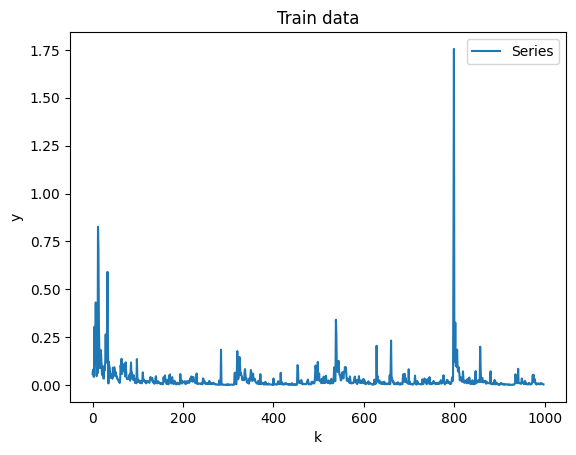

In [16]:
plot_line_series(ytrain, 'k', 'y', 'Train data')

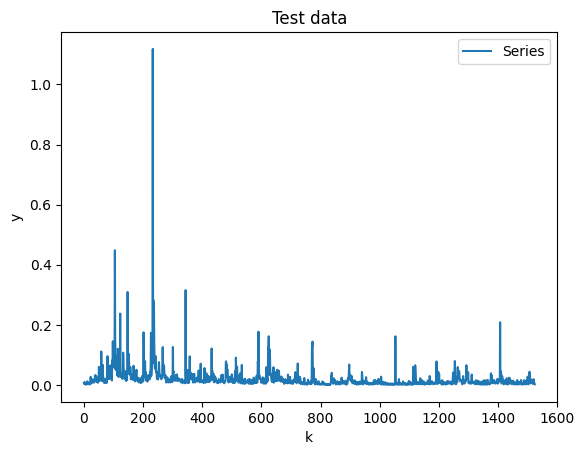

In [17]:
plot_line_series(ytest, 'k', 'y', 'Test data')

In [18]:
# Obtém o número de regras (granulações) com base na primeira amostra de Xtrain.
r = gaussgranules(Xtrain[0], centers, sigmas).size

In [19]:
r

2

## *Treinamento e teste do modelo*

In [34]:
# Treina o modelo.
OT, norm, u, P = train_model(
    Xtrain=Xtrain,
    ytrain=ytrain,
    r=r,
    lamb=lamb,
    alfa=alfa,
    kz=kz,
    zs=zs,
    centers=centers,
    sigmas=sigmas
)

CPU execution time (training): 0.16482556299999906 seconds


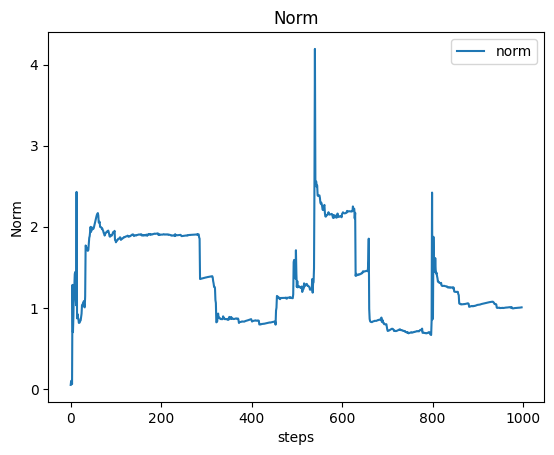

In [35]:
# Exibe a evolução da norma ao longo dos passos.
plot_line_series(norm, 'steps', 'Norm', 'Norm', 'norm')

In [22]:
# Exibe algumas métricas de erro de treinamento.
print('mse  train =', mean_squared_error(ytrain, OT))
print('nrms train =', root_mean_squared_error(ytrain, OT)/ytrain.std())
print('rmse train =', root_mean_squared_error(ytrain, OT))
print('mae  train =', mean_absolute_error(ytrain, OT))

mse  train = 0.00414300389954774
nrms train = 0.7879801733610144
rmse train = 0.06436617045892773
mae  train = 0.01838947390363763


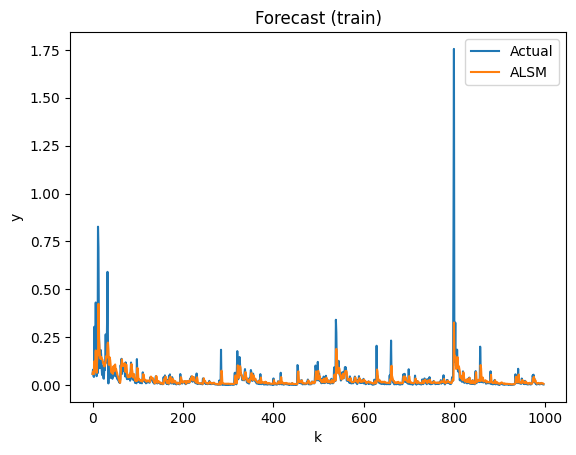

In [23]:
# Plota a série temporal prevista pelo modelo ALSM durante o treinamento em comparação com os valores reais (ytrain).
plot_comparison_series(ytrain, OT, 'k', 'y', 'Forecast (train)', ('Actual', 'ALSM'))

In [24]:
# Testa o modelo.
OS = test_model(
    Xtest=Xtest,
    ytest=ytest,
    r=r,
    lamb=lamb,
    P=P,
    u=u,
    centers=centers,
    sigmas=sigmas
)

CPU execution time (training): 0.2563893680000007 seconds


In [38]:
# Exibe algumas métricas de erro de teste.
print('MSE   test =', mean_squared_error(ytest, OS))
print('NRMSE test =', root_mean_squared_error(ytest, OS)/ytest.std())
print('RMSE  test =', root_mean_squared_error(ytest, OS))
print('MAE   test =', mean_absolute_error(ytest, OS))

MSE   test = 0.0011949922845992365
NRMSE test = 0.8366469919409039
RMSE  test = 0.03456866043975723
MAE   test = 0.011450247775351063


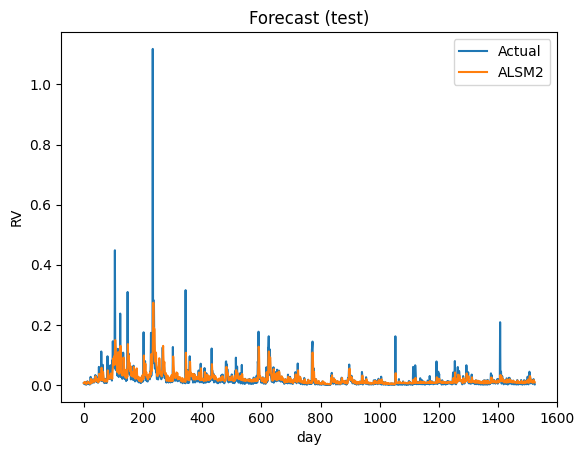

In [26]:
# Plota a série temporal prevista pelo modelo ALSM durante o teste em comparação com os valores reais (ytest).
plot_comparison_series(ytest, OS, 'day', 'RV', 'Forecast (test)', ('Actual', 'ALSM2'))